In [65]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time as ti
from itertools import count
import natsort
import datetime
import numpy as np
import os
import math

In [2]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import glob
import numpy
import random
import pandas as pd
import tqdm
torch.manual_seed(10)

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA A100-SXM4-40GB
cuda:0


In [4]:
class SurgicalDataset(Dataset):
    def __init__(self, image_paths, labels, transform=False):
        super(SurgicalDataset, self).__init__()
        self.image_paths = image_paths
        self.labels = labels    #.astype(dtype='int')
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        label = self.labels[idx]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [5]:
def get_transform(model_name):

    if model_name == 'alexnet':
        transform = A.Compose([
            A.Resize(227, 227),
            A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ToTensorV2(),
        ])

    elif model_name == 'effinet':
        transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ToTensorV2(),
        ])
        
    else:

        transform = A.Compose([
            A.Resize(224,224),
            A.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
            ToTensorV2(),
        ])
    
    return transform

In [6]:
train_image_paths = []
for i in range(1,71):
    filename = '/home/zo2151/assignments/Data/Video%i'%(i,)
    train_image_paths.append(glob.glob(filename + '/*'))
train_image_paths1 = [item for sublist in train_image_paths for item in sublist]
train_image_paths1 = natsort.natsorted(train_image_paths1)

In [7]:
df = pd.read_csv("/home/zo2151/Processed_data.csv")
df1 = df.loc[:,"Phases"].to_numpy()
df2 = df1.tolist()
percentile_list = pd.DataFrame(
    {'Link': train_image_paths1,
     'Label': df2,
    })

In [9]:
percentile_list1 = percentile_list.sample(frac=1, random_state=1)
train_image_paths = percentile_list1.loc[:,"Link"].to_numpy().tolist()
labels = percentile_list1.loc[:,"Label"].to_numpy().tolist()
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]  
train_labels, valid_labels = labels[:int(0.8*len(labels))], labels[int(0.8*len(labels)):] 

In [10]:
summary = {i:0 for i in range(14)}
num_classes = 14
total_samples = 0
for i in train_labels:
    total_samples += 1
    summary[i] += 1

class_weights = [total_samples/summary[i] for i in range(num_classes)]
weights = [class_weights[train_labels[i]] for i in range(total_samples)]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), len(weights))

In [11]:
class Classifier():

    def __init__(self, name, model, dataloaders, parameter, use_cuda=False):
        
        '''
        @name: Experiment name. Will define stored results etc. 
        @model: Any models
        @dataloaders: Dictionary with keys train, val and test and corresponding dataloaders
        @class_names: list of classes, where the idx of class name corresponds to the label used for it in the data
        @use_cuda: whether or not to use cuda
        '''
       
        self.name = name
        if use_cuda and not torch.cuda.is_available():
            raise Exception("Asked for CUDA but GPU not found")
            
        self.use_cuda = use_cuda
        self.epoch = parameter['epochs']
        self.lr = parameter['lr']
        self.batch_size = parameter['batch_size']
        
        self.model = model.to('cuda' if use_cuda else 'cpu') # model.to('cpu')
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.train_loader, self.valid_loader = self.get_dataloaders(dataloaders['train_image_paths'], 
                                                                    dataloaders['train_labels'], 
                                                                    dataloaders['valid_image_paths'], 
                                                                    dataloaders['valid_labels'], 
                                                                    train_transforms=dataloaders['transforms'], 
                                                                    batch_size = self.batch_size,
                                                                    shuffle=parameter['shuffle'],
                                                                   sampler = dataloaders['sampler'])
        self.class_names = parameter['class_names']
        
        self.activations_path = os.path.join('activations', self.name)
        self.kernel_path = os.path.join('kernel_viz', self.name)
        save_path = "/home/zo2151/"
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        if not os.path.exists(self.activations_path):
            os.makedirs(self.activations_path)

        if not os.path.exists(self.kernel_path):
            os.makedirs(self.kernel_path)
            
        self.save_path = save_path

    def train(self, save=True):
        '''
        @epochs: number of epochs to train
        @save: whether or not to save the checkpoints
        '''
        best_val_accuracy = - math.inf
        
        for epoch in range(self.epoch):  # loop over the dataset multiple times
            self.model.train()
            t = time.time()
            running_loss = 0.0
            train_acc = 0
            val_accuracy = 0
            correct = 0
            total = 0
            count = 0
            loop = tqdm.tqdm(self.train_loader, total = len(self.train_loader), leave = True)
            
            for img, label in loop:
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = img.to(device), label.to(device) #img.to(device), label.to(device)

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)
                _, predictions = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                total += labels.shape[0]
                correct += (predictions == labels).sum().item()
                
                count += 1
                if count % 2000 == 1999:    # print every 2000 mini-batches
                    print(f'[{epoch + 1}, {count + 1:5d}] loss: {running_loss / 2000:.3f}')
                    running_loss = 0.0
                    
            train_acc = 100 * correct / total
            print(f'Epoch:', epoch + 1, f'Training Epoch Accuracy:{train_acc}')
            
            # evaluate the validation dataset
            self.model.eval()
            correct_pred = {classname: 0 for classname in self.class_names}
            total_pred = {classname: 0 for classname in self.class_names}

            # again no gradients needed
            correct = 0
            total = 0
            with torch.no_grad():
                for data in self.valid_loader:
                    images, labels = data[0].to(device), data[1].to(device) #data[0], data[1]
                    outputs = self.model(images)
                    _, predictions = torch.max(outputs, 1)
                    # collect the correct predictions for each class
                    total += labels.shape[0]
                    correct += (predictions == labels).sum().item()

                    for label, prediction in zip(labels, predictions):
                        if label == prediction:
                            correct_pred[classes[label]] += 1
                        total_pred[classes[label]] += 1

            val_accuracy = 100 * correct / total
            print(f'Epoch:', epoch + 1, f'Validation Epoch Accuracy:{val_accuracy}')
                        
            # print the summary for each class
            print('Epoch:', epoch + 1, 'Correct predictions', correct_pred)
            print('Epoch:', epoch + 1, 'Total predictions', total_pred)
            print('Epoch:', epoch + 1, 'Correct predictions', correct_pred)
            print('Epoch:', epoch + 1, 'Total predictions', total_pred)
            
            # inspect the time taken to train one epoch
            d = time.time()-t
            print('Fininsh Trainig Epoch', epoch, '!', 'Time used:', d)
            
            if save:
                torch.save(self.model.state_dict(), os.path.join(self.save_path, "model4.pt"))
                if val_accuracy > best_val_accuracy:
                    torch.save(self.model.state_dict(), os.path.join(self.save_path, 'best.pt'))
                    best_val_accuracy = val_accuracy

        print('Done training!')                       

    
    def evaluate(self):
        # for evaluating the test dataset if there were any.
        try:
            assert os.path.exists(os.path.join(self.save_path, 'best.pt'))
            
        except:
            print('Please train first')
            return
        
        self.model.load_state_dict(torch.load(os.path.join(self.save_path, 'best.pt')))
        self.model.eval()
        
    def get_dataloaders(self, train_image_paths, train_labels, valid_image_paths, valid_labels, train_transforms=False, batch_size=32, shuffle=True, sampler = None):
        train_dataset = SurgicalDataset(train_image_paths,train_labels, train_transforms)
        val_dataset = SurgicalDataset(valid_image_paths,valid_labels, train_transforms)
        train_loader = DataLoader(train_dataset, batch_size, shuffle, sampler)
        valid_loader = DataLoader(val_dataset, batch_size, shuffle = True)
        return train_loader, valid_loader
    
    def grad_cam_on_input(self, img):
        
        try:
            assert os.path.exists(os.path.join(self.save_path, 'best.pt'))

        except:
            print('It appears you are testing the model without training. Please train first')
            return

        self.model.load_state_dict(torch.load(os.path.join(self.save_path, 'best.pt')))


        self.model.eval()
        img = img.to('cuda' if self.use_cuda else 'cpu')


        out = self.model(img)

        _, pred = torch.max(out, 1)

        predicted_class = self.class_names[int(pred)]
        print(f'Predicted class was {predicted_class}')

        out[:, pred].backward()
        gradients = self.model.get_gradient_activations()

        print('Gradients shape: ', f'{gradients.shape}')

        mean_gradients = torch.mean(gradients, [0, 2, 3]).cpu()
        activations = self.model.get_final_conv_layer(img).detach().cpu()

        print('Activations shape: ', f'{activations.shape}')

        for idx in range(activations.shape[1]):
            activations[:, idx, :, :] *= mean_gradients[idx]

        final_heatmap = np.maximum(torch.mean(activations, dim=1).squeeze(), 0)

        final_heatmap /= torch.max(final_heatmap)

        return final_heatmap

    def trained_kernel_viz(self):
        
        all_layers = [0, 3]
        all_filters = []
        for layer in all_layers:

            filters = self.model.conv_model[layer].weight
            all_filters.append(filters.detach().cpu().clone()[:8, :8, :, :])

        for filter_idx in range(len(all_filters)):

            filter = all_filters[filter_idx]
            print(filter.shape)
            filter = filter.contiguous().view(-1, 1, filter.shape[2], filter.shape[3])
            image = show_img(make_grid(filter))
            image = 255 * image
            cv2.imwrite(os.path.join(self.kernel_path, f'filter_layer{all_layers[filter_idx]}.jpg'), image)
    

    def activations_on_input(self, img):
        
        img = img.to('cuda' if self.use_cuda else 'cpu')

        all_layers = [0,3,6,8,10]
        all_viz = []
        
        # looking at the outputs of the relu
        for each in all_layers:

            current_model = self.model.conv_model[:each+1]
            current_out = current_model(img)
            all_viz.append(current_out.detach().cpu().clone()[:, :64, :, :])

        for viz_idx in range(len(all_viz)):

            viz = all_viz[viz_idx]
            viz = viz.view(-1, 1, viz.shape[2], viz.shape[3])
            image = show_img(make_grid(viz))
            image = 255 * image
            cv2.imwrite(os.path.join(self.activations_path, f'sample_layer{all_layers[viz_idx]}.jpg'), image)    
        

In [13]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
example_model = models.efficientnet_b7(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /home/zo2151/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

In [14]:
class TransferEffiNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_effi_net = models.efficientnet_b7(pretrained=True)
        self.conv_model = self.get_conv_layers()
        self.avg_pool = self.transition_layer()
        self.fc_model = self.get_fc_layers()
        self.activate_training_layers()

    def activate_training_layers(self):
        for name, param in self.conv_model.named_parameters():
            number = int(name.split('.')[1])
            # for all layers except the last conv layer, set param.requires_grad = False
            if number == 8:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
        for name, param in self.fc_model.named_parameters():
            # for all of these layers set param.requires_grad as True
            param.requires_grad = True

    def get_conv_layers(self):
        return self.base_effi_net.features

    def transition_layer(self):
        return self.base_effi_net.avgpool

    def get_fc_layers(self):
        return nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=2560, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=14, bias=True),
        )
    
    def forward(self, x):
        x = self.conv_model(x)   #call the conv layers
        x = self.avg_pool(x)  #call the avg pool layer
        x = torch.flatten(x, 1)
        x = self.fc_model(x)  #call fully connected layers  
        
        return x

In [15]:
name = 'TransferEffiNet'
classes = [i for i in range(14)]
transforms = get_transform('effinet')
dataloaders = {'train_image_paths': train_image_paths, 'train_labels' : train_labels, 'valid_image_paths': valid_image_paths, 'valid_labels':valid_labels, 'transforms':transforms, 'sampler':sampler}
parameters = {'lr': 0.001, 'epochs' : 5, 'batch_size':32, 'shuffle':False, 'class_names':classes}

model = TransferEffiNet()
classifier = Classifier(name, model, dataloaders, parameters, use_cuda=True)
classifier.train()

 37%|██████████████████████████▍                                            | 1999/5377 [10:36<17:27,  3.22it/s]

[1,  2000] loss: 0.621


 74%|████████████████████████████████████████████████████▊                  | 3999/5377 [20:54<07:03,  3.25it/s]

[1,  4000] loss: 0.412


100%|███████████████████████████████████████████████████████████████████████| 5377/5377 [27:58<00:00,  3.20it/s]


Epoch: 1 Training Epoch Accuracy:83.91176727019094
Epoch: 1 Validation Epoch Accuracy:85.82488607830373
Epoch: 1 Correct predictions {0: 51, 1: 18, 2: 561, 3: 5191, 4: 195, 5: 283, 6: 9109, 7: 2103, 8: 2534, 9: 5339, 10: 244, 11: 8905, 12: 392, 13: 1990}
Epoch: 1 Total predictions {0: 52, 1: 18, 2: 587, 3: 5470, 4: 213, 5: 288, 6: 11135, 7: 2177, 8: 3001, 9: 5799, 10: 247, 11: 10405, 12: 404, 13: 3216}
Epoch: 1 Correct predictions {0: 51, 1: 18, 2: 561, 3: 5191, 4: 195, 5: 283, 6: 9109, 7: 2103, 8: 2534, 9: 5339, 10: 244, 11: 8905, 12: 392, 13: 1990}
Epoch: 1 Total predictions {0: 52, 1: 18, 2: 587, 3: 5470, 4: 213, 5: 288, 6: 11135, 7: 2177, 8: 3001, 9: 5799, 10: 247, 11: 10405, 12: 404, 13: 3216}
Fininsh Trainig Epoch 0 ! Time used: 2064.4031040668488


 37%|██████████████████████████▍                                            | 1999/5377 [10:12<17:08,  3.28it/s]

[2,  2000] loss: 0.312


 74%|████████████████████████████████████████████████████▊                  | 3999/5377 [20:23<06:59,  3.28it/s]

[2,  4000] loss: 0.290


100%|███████████████████████████████████████████████████████████████████████| 5377/5377 [27:23<00:00,  3.27it/s]


Epoch: 2 Training Epoch Accuracy:90.37867999651255
Epoch: 2 Validation Epoch Accuracy:91.16060634241607
Epoch: 2 Correct predictions {0: 51, 1: 17, 2: 563, 3: 5073, 4: 190, 5: 283, 6: 10310, 7: 2116, 8: 2533, 9: 5361, 10: 247, 11: 9797, 12: 401, 13: 2268}
Epoch: 2 Total predictions {0: 52, 1: 18, 2: 587, 3: 5470, 4: 213, 5: 288, 6: 11135, 7: 2177, 8: 3001, 9: 5799, 10: 247, 11: 10405, 12: 404, 13: 3216}
Epoch: 2 Correct predictions {0: 51, 1: 17, 2: 563, 3: 5073, 4: 190, 5: 283, 6: 10310, 7: 2116, 8: 2533, 9: 5361, 10: 247, 11: 9797, 12: 401, 13: 2268}
Epoch: 2 Total predictions {0: 52, 1: 18, 2: 587, 3: 5470, 4: 213, 5: 288, 6: 11135, 7: 2177, 8: 3001, 9: 5799, 10: 247, 11: 10405, 12: 404, 13: 3216}
Fininsh Trainig Epoch 1 ! Time used: 2006.2973544597626


 37%|██████████████████████████▍                                            | 1999/5377 [10:13<23:57,  2.35it/s]

[3,  2000] loss: 0.261


 74%|████████████████████████████████████████████████████▊                  | 3999/5377 [23:39<09:18,  2.47it/s]

[3,  4000] loss: 0.241


100%|███████████████████████████████████████████████████████████████████████| 5377/5377 [31:49<00:00,  2.82it/s]


Epoch: 3 Training Epoch Accuracy:91.92420587636956
Epoch: 3 Validation Epoch Accuracy:92.81828326978517
Epoch: 3 Correct predictions {0: 51, 1: 17, 2: 567, 3: 5233, 4: 191, 5: 282, 6: 10696, 7: 2138, 8: 2505, 9: 5458, 10: 245, 11: 9839, 12: 394, 13: 2307}
Epoch: 3 Total predictions {0: 52, 1: 18, 2: 587, 3: 5470, 4: 213, 5: 288, 6: 11135, 7: 2177, 8: 3001, 9: 5799, 10: 247, 11: 10405, 12: 404, 13: 3216}
Epoch: 3 Correct predictions {0: 51, 1: 17, 2: 567, 3: 5233, 4: 191, 5: 282, 6: 10696, 7: 2138, 8: 2505, 9: 5458, 10: 245, 11: 9839, 12: 394, 13: 2307}
Epoch: 3 Total predictions {0: 52, 1: 18, 2: 587, 3: 5470, 4: 213, 5: 288, 6: 11135, 7: 2177, 8: 3001, 9: 5799, 10: 247, 11: 10405, 12: 404, 13: 3216}
Fininsh Trainig Epoch 2 ! Time used: 2272.039259672165


 37%|██████████████████████████▍                                            | 1999/5377 [10:07<17:12,  3.27it/s]

[4,  2000] loss: 0.220


 74%|████████████████████████████████████████████████████▊                  | 3999/5377 [20:15<06:56,  3.30it/s]

[4,  4000] loss: 0.213


100%|███████████████████████████████████████████████████████████████████████| 5377/5377 [27:13<00:00,  3.29it/s]


Epoch: 4 Training Epoch Accuracy:93.23316574152112
Epoch: 4 Validation Epoch Accuracy:92.2347251929694
Epoch: 4 Correct predictions {0: 52, 1: 17, 2: 573, 3: 5085, 4: 199, 5: 286, 6: 10481, 7: 2109, 8: 2657, 9: 5668, 10: 246, 11: 9516, 12: 399, 13: 2384}
Epoch: 4 Total predictions {0: 52, 1: 18, 2: 587, 3: 5470, 4: 213, 5: 288, 6: 11135, 7: 2177, 8: 3001, 9: 5799, 10: 247, 11: 10405, 12: 404, 13: 3216}
Epoch: 4 Correct predictions {0: 52, 1: 17, 2: 573, 3: 5085, 4: 199, 5: 286, 6: 10481, 7: 2109, 8: 2657, 9: 5668, 10: 246, 11: 9516, 12: 399, 13: 2384}
Epoch: 4 Total predictions {0: 52, 1: 18, 2: 587, 3: 5470, 4: 213, 5: 288, 6: 11135, 7: 2177, 8: 3001, 9: 5799, 10: 247, 11: 10405, 12: 404, 13: 3216}
Fininsh Trainig Epoch 3 ! Time used: 1996.2453582286835


 37%|██████████████████████████▍                                            | 1999/5377 [10:06<16:57,  3.32it/s]

[5,  2000] loss: 0.202


 74%|████████████████████████████████████████████████████▊                  | 3999/5377 [20:13<06:57,  3.30it/s]

[5,  4000] loss: 0.190


100%|███████████████████████████████████████████████████████████████████████| 5377/5377 [27:11<00:00,  3.30it/s]


Epoch: 5 Training Epoch Accuracy:93.93937632596123
Epoch: 5 Validation Epoch Accuracy:93.02055240398029
Epoch: 5 Correct predictions {0: 52, 1: 18, 2: 560, 3: 5325, 4: 187, 5: 281, 6: 10528, 7: 2090, 8: 2665, 9: 5674, 10: 246, 11: 9608, 12: 401, 13: 2375}
Epoch: 5 Total predictions {0: 52, 1: 18, 2: 587, 3: 5470, 4: 213, 5: 288, 6: 11135, 7: 2177, 8: 3001, 9: 5799, 10: 247, 11: 10405, 12: 404, 13: 3216}
Epoch: 5 Correct predictions {0: 52, 1: 18, 2: 560, 3: 5325, 4: 187, 5: 281, 6: 10528, 7: 2090, 8: 2665, 9: 5674, 10: 246, 11: 9608, 12: 401, 13: 2375}
Epoch: 5 Total predictions {0: 52, 1: 18, 2: 587, 3: 5470, 4: 213, 5: 288, 6: 11135, 7: 2177, 8: 3001, 9: 5799, 10: 247, 11: 10405, 12: 404, 13: 3216}
Fininsh Trainig Epoch 4 ! Time used: 1995.0119655132294
Done training!


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns

In [17]:
class TransferEffiNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_effi_net = models.efficientnet_b7(pretrained=True)
        self.conv_model = self.get_conv_layers()
        self.avg_pool = self.transition_layer()
        self.fc_model = self.get_fc_layers()
        self.activate_training_layers()

    def activate_training_layers(self):
        for name, param in self.conv_model.named_parameters():
            number = int(name.split('.')[1])
            # for all layers except the last conv layer, set param.requires_grad = False
            if number == 8:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
        for name, param in self.fc_model.named_parameters():
            # for all of these layers set param.requires_grad as True
            param.requires_grad = True

    def get_conv_layers(self):
        return self.base_effi_net.features

    def transition_layer(self):
        return self.base_effi_net.avgpool

    def get_fc_layers(self):
        return nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=2560, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=14, bias=True),
        )
    
    def forward(self, x):
        x = self.conv_model(x)   #call the conv layers
        x = self.avg_pool(x)  #call the avg pool layer
        x = torch.flatten(x, 1)
        x = self.fc_model(x)  #call fully connected layers  
        
        return x
    
    

In [19]:
def get_pred(model, train_transforms, batch_size, use_cuda=True):
    val_dataset = SurgicalDataset(valid_image_paths, valid_labels, train_transforms)
    valid_loader = DataLoader(val_dataset, batch_size, shuffle = False)
    model = model.to('cuda' if use_cuda else 'cpu')
    pr = []
    pred = []
    l = []
    # again no gradients needed
    t = time.time()
    negative_examples = []
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data[0].to(device), data[1].to(device)
            l.append(labels)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            m = F.softmax(outputs, dim=1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                pred.append(prediction)
            for p in m:
                pr.append(p)
                
    processtime = time.time()-t
    print('processtime', processtime)
    return l, pred, pr, processtime

In [20]:
classes = ['adhesiolysis', 'blurry', 'catheter insertion', 'mesh placement', 'mesh positioning', 'out of body', 'peritoneal closure', 'peritoneal scoring', 
          'positioning suture', 'preperioneal dissection', 'primary hernia repair', 'reduction of hernia', 'stationary idle', 'transitionary idle']
save_path = os.path.join(os.getcwd(), 'models', 'TransferEffiNet')
best_effi = TransferEffiNet()
best_effi.load_state_dict(torch.load(os.path.join(save_path, 'best.pt')))
transforms = get_transform('effinet')
batch_size = 32
y_test_true, y_test_predicted, pr, time = get_pred(best_effi, transforms, batch_size)

processtime 330.7153015136719


NameError: name 'get_to_cpu' is not defined

In [22]:
def get_to_cpu(l, pred, pr):
    for i in range(len(l)):
        l[i] = l[i].cpu()
    for i in range(len(l)):
        l[i] = l[i].data.numpy()
    l = [item for sublist in l for item in sublist]
    for i in range(len(l)):
        pred[i] = pred[i].cpu().data.numpy()
    for i in range(len(l)):
        pr[i] = pr[i].cpu().data.numpy()
    return l, pred, pr

def get_class_names(y_true, y_predicted, classes):
    yt = [classes[i] for i in y_true]
    yp = [classes[i] for i in y_predicted]
    return yt, yp
y_test_true, y_test_predicted, pr = get_to_cpu(y_test_true, y_test_predicted, pr)

In [30]:
classes = ['adhesiolysis', 'blurry', 'catheter insertion', 'mesh placement', 'mesh positioning', 'out of body', 'peritoneal closure', 'peritoneal scoring', 
          'positioning suture', 'preperioneal dissection', 'primary hernia repair', 'reduction of hernia', 'stationary idle', 'transitionary idle']
y_true, y_predicted = get_class_names(y_test_true, y_test_predicted, classes)

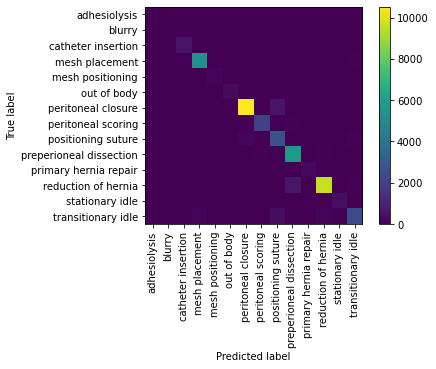

{'adhesiolysis': {'precision': 0.8813559322033898, 'recall': 1.0, 'f1-score': 0.936936936936937, 'support': 52}, 'blurry': {'precision': 0.9473684210526315, 'recall': 1.0, 'f1-score': 0.972972972972973, 'support': 18}, 'catheter insertion': {'precision': 0.9271523178807947, 'recall': 0.9540034071550255, 'f1-score': 0.9403862300587741, 'support': 587}, 'mesh placement': {'precision': 0.9596323661921067, 'recall': 0.973491773308958, 'f1-score': 0.9665123876939831, 'support': 5470}, 'mesh positioning': {'precision': 0.684981684981685, 'recall': 0.8779342723004695, 'f1-score': 0.7695473251028806, 'support': 213}, 'out of body': {'precision': 0.972318339100346, 'recall': 0.9756944444444444, 'f1-score': 0.9740034662045061, 'support': 288}, 'peritoneal closure': {'precision': 0.9754470490132493, 'recall': 0.9454872025145936, 'f1-score': 0.9602334914264866, 'support': 11135}, 'peritoneal scoring': {'precision': 0.9491371480472298, 'recall': 0.9600367478180983, 'f1-score': 0.9545558346654487, '

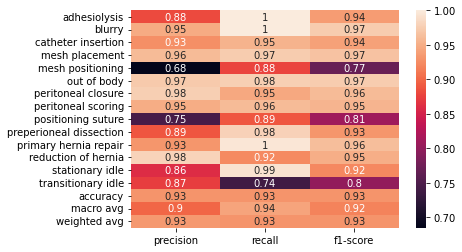

In [31]:
cm = confusion_matrix(y_true, y_predicted, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(include_values=False, xticks_rotation = 'vertical')
plt.show()

target_names = classes
c_report = classification_report(y_true, y_predicted, labels=classes, target_names=target_names, output_dict=True)
print(c_report)
basic_report = classification_report(y_true, y_predicted, labels=classes)
print(basic_report)
sns.heatmap(pd.DataFrame(c_report).iloc[:-1, :].T, annot=True)

print(metrics.roc_auc_score(y_test_true, pr, multi_class = 'ovr'))
print(metrics.roc_auc_score(y_test_true, pr, multi_class = 'ovo')) 

In [45]:
train_image_paths = []
for i in range(71,100):
    filename = '/home/zo2151/assignments/Data1/Test_data/001-00%i'%(i,)
    train_image_paths.append(glob.glob(filename + '/*'))
train_image_paths1 = [item for sublist in train_image_paths for item in sublist]
train_image_paths1.extend(train_image_paths4)

In [ ]:
train_image_paths = []
for i in range(100,126):
    filename = '/home/zo2151/assignments/Data1/Test_data/001-0%i'%(i,)
    train_image_paths.append(glob.glob(filename + '/*'))
train_image_paths2 = [item for sublist in train_image_paths for item in sublist]
train_image_paths1.extend(train_image_paths4)

In [ ]:
train_image_paths = []
for i in range(1,5):
    filename = '/home/zo2151/assignments/Data1/Test_data/002-000%i'%(i,)
    train_image_paths.append(glob.glob(filename + '/*'))
train_image_paths3 = [item for sublist in train_image_paths for item in sublist]
train_image_paths1.extend(train_image_paths4)

In [51]:
train_image_paths = []
for i in range(1,2):
    filename = '/home/zo2151/assignments/Data1/Test_data/003-000%i'%(i,)
    train_image_paths.append(glob.glob(filename + '/*'))
train_image_paths4 = [item for sublist in train_image_paths for item in sublist]
train_image_paths1.extend(train_image_paths4)

In [52]:
len(train_image_paths1)

180191

In [53]:
train_image_paths1 = natsort.natsorted(train_image_paths1)

In [56]:
names = []
for i in range(len(train_image_paths1)):
    a = os.path.basename(train_image_paths1[i])
    a1 = a[:-4]
    names.append(a1)

In [58]:
train_transforms = A.Compose(
    [
        A.Resize(224,224),
        A.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
        ToTensorV2(),
    ]
)

In [63]:
class SurgicalDataset1(Dataset):
    def __init__(self, image_paths, transform=False):
        super(SurgicalDataset1, self).__init__()
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image

In [72]:
def get_pred1(model, train_transforms, batch_size, use_cuda=True):
    val_dataset = SurgicalDataset1(train_image_paths1, train_transforms)
    valid_loader = DataLoader(val_dataset, batch_size, shuffle = False)
    model = model.to('cuda' if use_cuda else 'cpu')
    pred = []
    # again no gradients needed
    t = ti.time()
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            images= data.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for prediction in predictions:
                pred.append(prediction)
                
    processtime = ti.time()-t
    print('processtime', processtime)
    return pred, processtime

In [73]:
save_path = os.path.join(os.getcwd(), 'models', 'TransferEffiNet')
best_effi = TransferEffiNet()
best_effi.load_state_dict(torch.load(os.path.join(save_path, 'best.pt')))
transforms = get_transform('effinet')
batch_size = 32
y_test_predicted, time = get_pred1(best_effi, transforms, batch_size)

processtime 1381.637146949768


In [76]:
for i in range(len(y_test_predicted)):
    y_test_predicted[i] = y_test_predicted[i].cpu().data.numpy()

In [77]:
d = {'Id': names, 'Predicted': y_test_predicted}

In [78]:
df = pd.concat([pd.Series(v, name=k) for k, v in d.items()], axis=1)

In [80]:
df.to_csv("Predicted.csv", index = False)

In [81]:
some_csv = pd.read_csv("kaggle_template.csv")

In [82]:
names1 = some_csv["Id"]

In [92]:
names1 = some_csv["Id"].values.tolist()

In [93]:
names2 = []
y_test_predicted1 = []

In [94]:
for i in range(len(names)):
    if names[i] in names1:
        names2.append(names[i])
        y_test_predicted1.append(y_test_predicted[i])

In [130]:
len(y_test_predicted1)

179928

In [149]:
d1 = {'Id': names3, 'Predicted': y_test_predicted2}

In [150]:
df = pd.concat([pd.Series(v, name=k) for k, v in d1.items()], axis=1)

In [151]:
df.to_csv("Predicted.csv", index = False)

In [141]:
names3=[]

In [142]:
# The labels are using 0-based index, which is different from the final prediction label example. Only one set of labels 
# were submitted due to time constraint.
for i in range(len(names2)):
    if names2[i][-2] == "-":
        n = int(names2[i][-1:])
        na = names2[i][0:-1]+"0000%i"%(n)
        names3.append(na)
    elif names2[i][-3] == "-":
        n = int(names2[i][-2:])
        na = names2[i][0:-2]+"000%i"%(n)
        names3.append(na)
    elif names2[i][-4] == "-":
        n = int(names2[i][-3:])
        na = names2[i][0:-3]+"00%i"%(n)
        names3.append(na)
    elif names2[i][-5] == "-":
        n = int(names2[i][-4:])
        na = names2[i][0:-4]+"0%i"%(n)
        names3.append(na)

In [148]:
y_test_predicted2 = []
for i in range(len(y_test_predicted1)):
    if y_test_predicted1[i] == 0:
        y_test_predicted2.append("adhesiolysis")
    elif y_test_predicted1[i] == 1:
        y_test_predicted2.append("blurry")
    elif y_test_predicted1[i] == 2:
        y_test_predicted2.append("catheter insertion")
    elif y_test_predicted1[i] == 3:
        y_test_predicted2.append("mesh placement")
    elif y_test_predicted1[i] == 4:
        y_test_predicted2.append("mesh positioning")
    elif y_test_predicted1[i] == 5:
        y_test_predicted2.append("out of body")
    elif y_test_predicted1[i] == 6:
        y_test_predicted2.append("peritoneal closure")
    elif y_test_predicted1[i] == 7:
        y_test_predicted2.append("peritoneal scoring")
    elif y_test_predicted1[i] == 8:
        y_test_predicted2.append("positioning suture")
    elif y_test_predicted1[i] == 9:
        y_test_predicted2.append("preperioneal dissection")
    elif y_test_predicted1[i] == 10:
        y_test_predicted2.append("primary hernia repair")
    elif y_test_predicted1[i] == 11:
        y_test_predicted2.append("reduction of hernia")
    elif y_test_predicted1[i] == 12:
        y_test_predicted2.append("stationary idle")
    elif y_test_predicted1[i] == 13:
        y_test_predicted2.append("transitionary idle")